# EDA on the aapl historical data
This notebook will use AAPL - stock on the EDA.  
The purpose of this notebook is to explore the dataset, understand its features, and examine how it is structured. We will also experiment with different models. We will be implement the model architectures in use in the ml_model package so it can be reused in other notebooks.

### Imports

In [52]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras as ks

sys.path.append(str(Path("..").resolve()))
from src.ml_model.data import fetch_data

### Reading Data

In [4]:
df = fetch_data("AAPL", (2020, 1, 1), (2024, 12, 31))
df.head()

open      high      low   close  \
symbol timestamp                                                      
AAPL   2020-01-02 05:00:00+00:00  296.24  300.6000  295.190  300.35   
       2020-01-03 05:00:00+00:00  297.15  300.5800  296.500  297.43   
       2020-01-06 05:00:00+00:00  293.79  299.9600  292.750  299.80   
       2020-01-07 05:00:00+00:00  299.84  300.9000  297.480  298.39   
       2020-01-08 05:00:00+00:00  297.16  304.4399  297.156  303.19   

                                      volume  trade_count        vwap  
symbol timestamp                                                       
AAPL   2020-01-02 05:00:00+00:00  36554338.0     283489.0  298.546196  
       2020-01-03 05:00:00+00:00  38677814.0     280441.0  298.834372  
       2020-01-06 05:00:00+00:00  31399992.0     242868.0  297.813476  
       2020-01-07 05:00:00+00:00  29556784.0     227871.0  299.034972  
       2020-01-08 05:00:00+00:00  35684201.0     261773.0  301.304133

In [5]:
# Checking its index
print(df.index)

MultiIndex([('AAPL', '2020-01-02 05:00:00+00:00'),
            ('AAPL', '2020-01-03 05:00:00+00:00'),
            ('AAPL', '2020-01-06 05:00:00+00:00'),
            ('AAPL', '2020-01-07 05:00:00+00:00'),
            ('AAPL', '2020-01-08 05:00:00+00:00'),
            ('AAPL', '2020-01-09 05:00:00+00:00'),
            ('AAPL', '2020-01-10 05:00:00+00:00'),
            ('AAPL', '2020-01-13 05:00:00+00:00'),
            ('AAPL', '2020-01-14 05:00:00+00:00'),
            ('AAPL', '2020-01-15 05:00:00+00:00'),
            ...
            ('AAPL', '2024-12-16 05:00:00+00:00'),
            ('AAPL', '2024-12-17 05:00:00+00:00'),
            ('AAPL', '2024-12-18 05:00:00+00:00'),
            ('AAPL', '2024-12-19 05:00:00+00:00'),
            ('AAPL', '2024-12-20 05:00:00+00:00'),
            ('AAPL', '2024-12-23 05:00:00+00:00'),
            ('AAPL', '2024-12-24 05:00:00+00:00'),
            ('AAPL', '2024-12-26 05:00:00+00:00'),
            ('AAPL', '2024-12-27 05:00:00+00:00'),
            ('A

In [6]:
# Index is a multi-index, switching to just datetime index
df.reset_index(inplace = True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

### Data Exploration & Visualization

In [7]:
df.describe()

,open,high,low,close,volume,trade_count,vwap
count,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1.257000e+03,1257.000000
mean,186.899460,189.115343,184.920610,187.153390,7.836307e+07,6.460142e+05,187.103653
std,68.176713,69.126859,67.434968,68.447561,4.033381e+07,2.602545e+05,68.356699
min,104.540000,110.190000,103.100000,106.840000,2.120553e+07,1.759620e+05,107.056297
25%,144.030000,146.450000,142.652200,144.800000,5.019057e+07,5.020590e+05,144.720128
50%,169.580000,171.170000,168.230200,169.590000,7.042244e+07,5.968510e+05,169.663231
75%,196.060000,197.080000,194.390000,195.870000,9.590132e+07,7.332770e+05,195.883235
max,514.790000,515.140000,500.330000,506.090000,3.570209e+08,2.962331e+06,505.287645


In [8]:
# Checking for missing data
print("Total missing values:", df.isnull().sum().sum())
print(df.isnull().sum())

Total missing values: 0
symbol         0
open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
dtype: int64


In [9]:
# Checking for duplicates
print("Total duplicates:", df.duplicated().sum())

Total duplicates: 0


<Axes: title={'center': 'Stock OHLC Prices'}, xlabel='timestamp'>

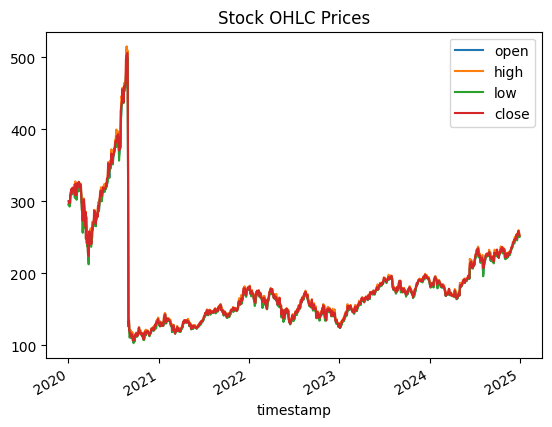

In [10]:
# Time-Series Price Plots
df[['open', 'high', 'low', 'close']].plot(title = 'Stock OHLC Prices')

,symbol,open,high,low,close,volume,trade_count,vwap,MA50,MA200
timestamp,,,,,,,,,,
2020-01-02 05:00:00+00:00,AAPL,296.24,300.6000,295.190,300.35,36554338.0,283489.0,298.546196,NaN,NaN
2020-01-03 05:00:00+00:00,AAPL,297.15,300.5800,296.500,297.43,38677814.0,280441.0,298.834372,NaN,NaN
2020-01-06 05:00:00+00:00,AAPL,293.79,299.9600,292.750,299.80,31399992.0,242868.0,297.813476,NaN,NaN
2020-01-07 05:00:00+00:00,AAPL,299.84,300.9000,297.480,298.39,29556784.0,227871.0,299.034972,NaN,NaN
2020-01-08 05:00:00+00:00,AAPL,297.16,304.4399,297.156,303.19,35684201.0,261773.0,301.304133,NaN,NaN


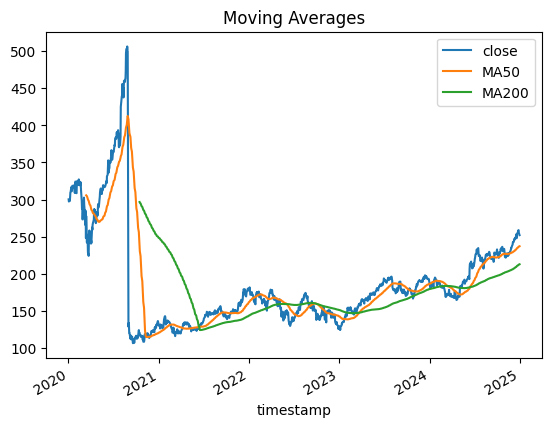

In [11]:
# Moving Averages
df['MA50'] = df['close'].rolling(50).mean()
df['MA200'] = df['close'].rolling(200).mean()
df[['close','MA50','MA200']].plot(title = 'Moving Averages')
df.head()

### Feature Engineering & Visualization
We are going to restart the data reading to implement all feature engineering under this section.

In [12]:
df = fetch_data("AAPL", (2020, 1, 1), (2025, 9, 14))
# Index is a multi-index
df.reset_index(inplace = True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace = True)

In [13]:
print(df)

                          symbol     open      high      low   close  \
timestamp                                                              
2020-01-02 05:00:00+00:00   AAPL  296.240  300.6000  295.190  300.35   
2020-01-03 05:00:00+00:00   AAPL  297.150  300.5800  296.500  297.43   
2020-01-06 05:00:00+00:00   AAPL  293.790  299.9600  292.750  299.80   
2020-01-07 05:00:00+00:00   AAPL  299.840  300.9000  297.480  298.39   
2020-01-08 05:00:00+00:00   AAPL  297.160  304.4399  297.156  303.19   
...                          ...      ...       ...      ...     ...   
2025-09-08 04:00:00+00:00   AAPL  239.300  240.1500  236.340  237.88   
2025-09-09 04:00:00+00:00   AAPL  237.000  238.7805  233.360  234.35   
2025-09-10 04:00:00+00:00   AAPL  232.185  232.4200  225.950  226.79   
2025-09-11 04:00:00+00:00   AAPL  226.875  230.4500  226.650  230.03   
2025-09-12 04:00:00+00:00   AAPL  229.220  234.5100  229.020  234.07   

                               volume  trade_count        vwap 

<Axes: title={'center': 'Stock OHLC Prices'}, xlabel='timestamp'>

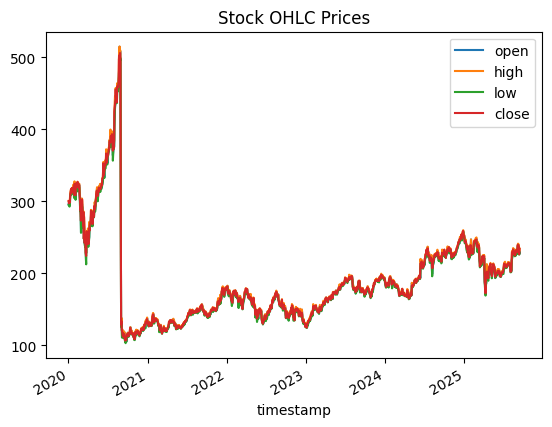

In [14]:
# Time-Series Price Plots
df[['open', 'high', 'low', 'close']].plot(title = 'Stock OHLC Prices')

In [15]:
# Adding more feautures like SMA
df['SMA5']  = df['close'].rolling(window=5).mean()
df['SMA20'] = df['close'].rolling(window=20).mean()
df['SMA50'] = df['close'].rolling(window=50).mean()

# Adding price change
df['price_change'] = df['close'].diff()

In [16]:
# Calculating and adding RSI
window = 14
delta = df['close'].diff()

gain = delta.clip(lower = 0)
loss = -delta.clip(upper = 0)

avg_gain = gain.rolling(window = window).mean()
avg_loss = loss.rolling(window = window).mean()

rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

In [17]:
# Short-term EMA (12), long-term EMA (26)
ema12 = df['close'].ewm(span = 12, adjust = False).mean()
ema26 = df['close'].ewm(span = 26, adjust = False).mean()

# MACD line
df['MACD'] = ema12 - ema26

# Signal line (9-day EMA of MACD)
df['MACD_Signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1432 entries, 2020-01-02 05:00:00+00:00 to 2025-09-12 04:00:00+00:00
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   symbol        1432 non-null   object 
 1   open          1432 non-null   float64
 2   high          1432 non-null   float64
 3   low           1432 non-null   float64
 4   close         1432 non-null   float64
 5   volume        1432 non-null   float64
 6   trade_count   1432 non-null   float64
 7   vwap          1432 non-null   float64
 8   SMA5          1428 non-null   float64
 9   SMA20         1413 non-null   float64
 10  SMA50         1383 non-null   float64
 11  price_change  1431 non-null   float64
 12  RSI           1418 non-null   float64
 13  MACD          1432 non-null   float64
 14  MACD_Signal   1432 non-null   float64
dtypes: float64(14), object(1)
memory usage: 179.0+ KB
None


In [19]:
# Checking for missing values
print(df.isnull().sum())

symbol           0
open             0
high             0
low              0
close            0
volume           0
trade_count      0
vwap             0
SMA5             4
SMA20           19
SMA50           49
price_change     1
RSI             14
MACD             0
MACD_Signal      0
dtype: int64


In [20]:
# The fist 49 values have missing values that can not be replaces by statistics. Therefore we will choose to remove them:
df = df.dropna()

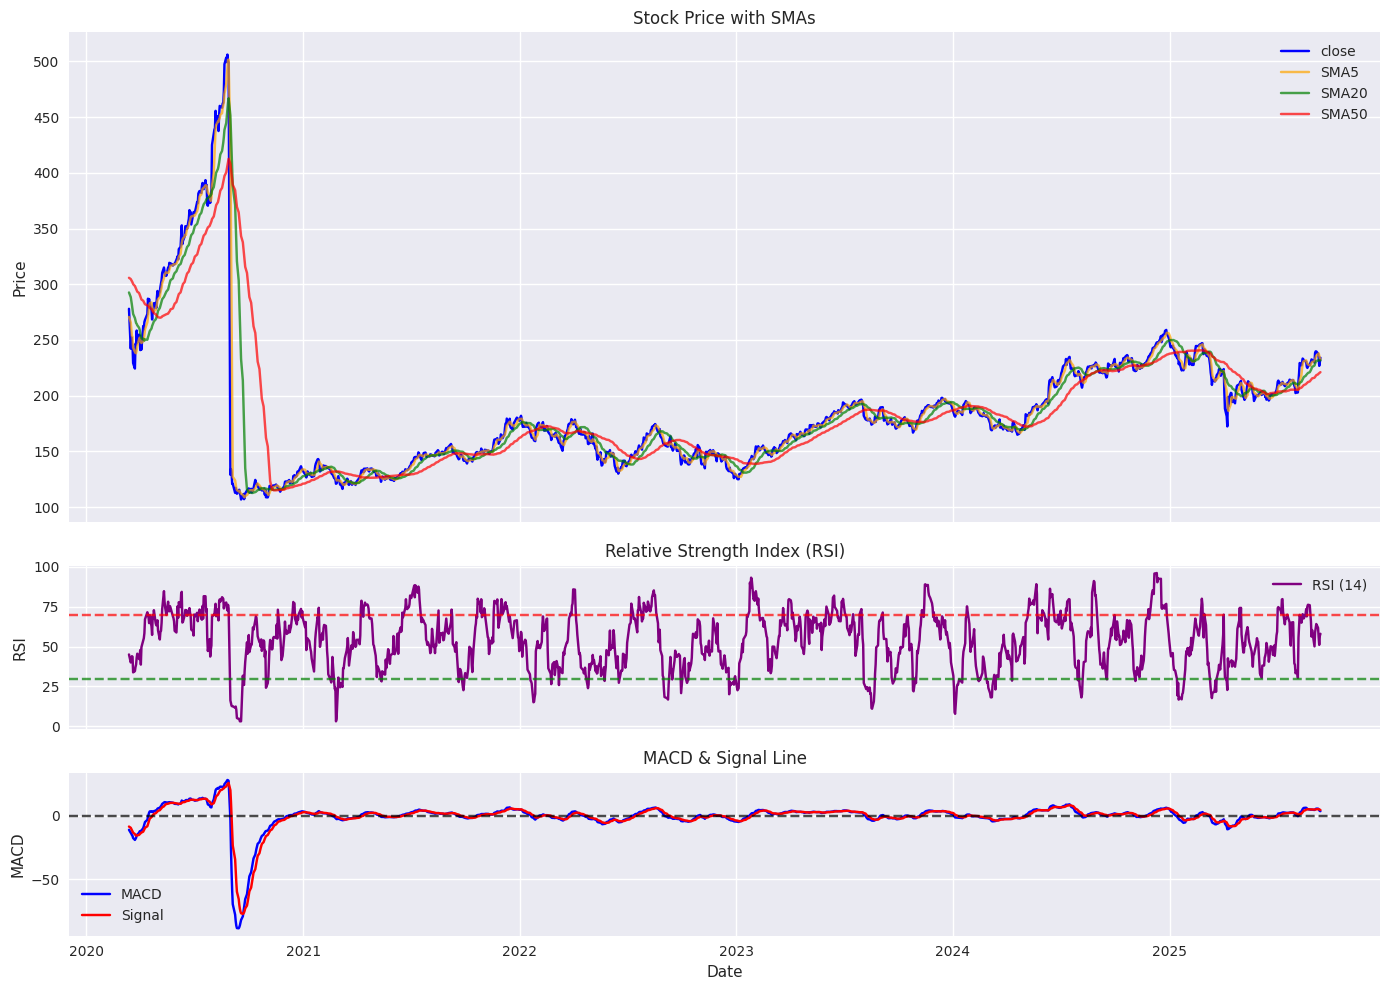

In [21]:
# Plotting
plt.style.use("seaborn-v0_8")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True,
                                    gridspec_kw={'height_ratios':[3,1,1]})

# SMA plot
ax1.plot(df.index, df['close'], label = 'close', color = 'blue')
ax1.plot(df.index, df['SMA5'], label = 'SMA5', color = 'orange', alpha = 0.7)
ax1.plot(df.index, df['SMA20'], label = 'SMA20', color = 'green', alpha = 0.7)
ax1.plot(df.index, df['SMA50'], label = 'SMA50', color = 'red', alpha = 0.7)
ax1.set_title("Stock Price with SMAs")
ax1.set_ylabel("Price")
ax1.legend()

# RSI plot
ax2.plot(df.index, df['RSI'], label = 'RSI (14)', color = 'purple')
ax2.axhline(70, color = 'red', linestyle = '--', alpha = 0.7)   # Overbought
ax2.axhline(30, color = 'green', linestyle = '--', alpha = 0.7) # Oversold
ax2.set_title("Relative Strength Index (RSI)")
ax2.set_ylabel("RSI")
ax2.legend()

# MACD plot
ax3.plot(df.index, df['MACD'], label = 'MACD', color = 'blue')
ax3.plot(df.index, df['MACD_Signal'], label = 'Signal', color = 'red')
ax3.axhline(0, color = 'black', linestyle = '--', alpha = 0.7)
ax3.set_title("MACD & Signal Line")
ax3.set_ylabel("MACD")
ax3.legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


##### We can make the ML model predict if tommorow's close is higher or lower (classification) with 1 or 0.

/tmp/ipykernel_14579/1382313785.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'target', data = df, palette = 'Set2')


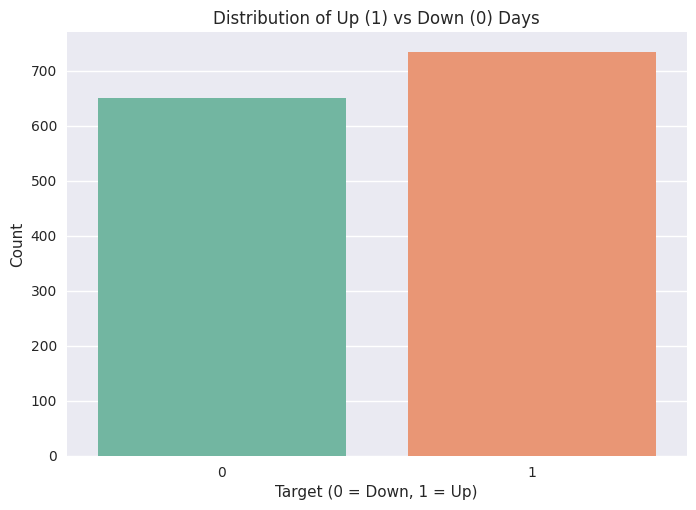

In [22]:
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

sns.countplot(x = 'target', data = df, palette = 'Set2')
plt.title("Distribution of Up (1) vs Down (0) Days")
plt.xlabel("Target (0 = Down, 1 = Up)")
plt.ylabel("Count")
plt.show()


/tmp/ipykernel_14579/1620674127.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'target', y = 'RSI', data = df, palette = 'Set1')


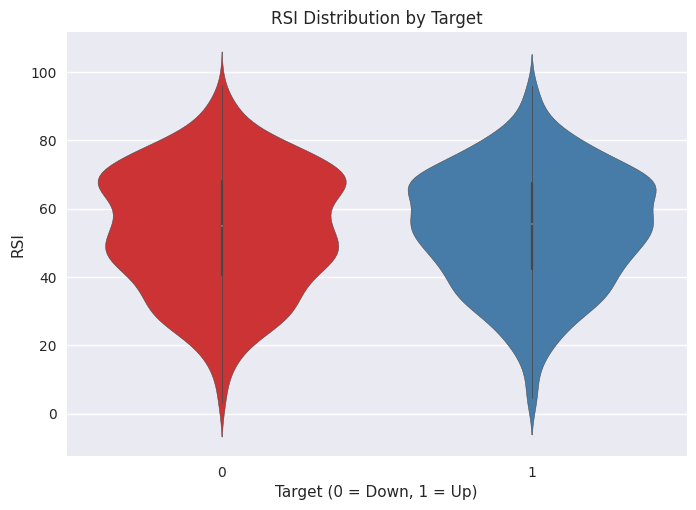

In [23]:
sns.violinplot(x = 'target', y = 'RSI', data = df, palette = 'Set1')
plt.title("RSI Distribution by Target")
plt.xlabel("Target (0 = Down, 1 = Up)")
plt.ylabel("RSI")
plt.show()


In [24]:
# Just reminding our self which features we have
print(df.columns)

Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count',
       'vwap', 'SMA5', 'SMA20', 'SMA50', 'price_change', 'RSI', 'MACD',
       'MACD_Signal', 'target'],
      dtype='object')


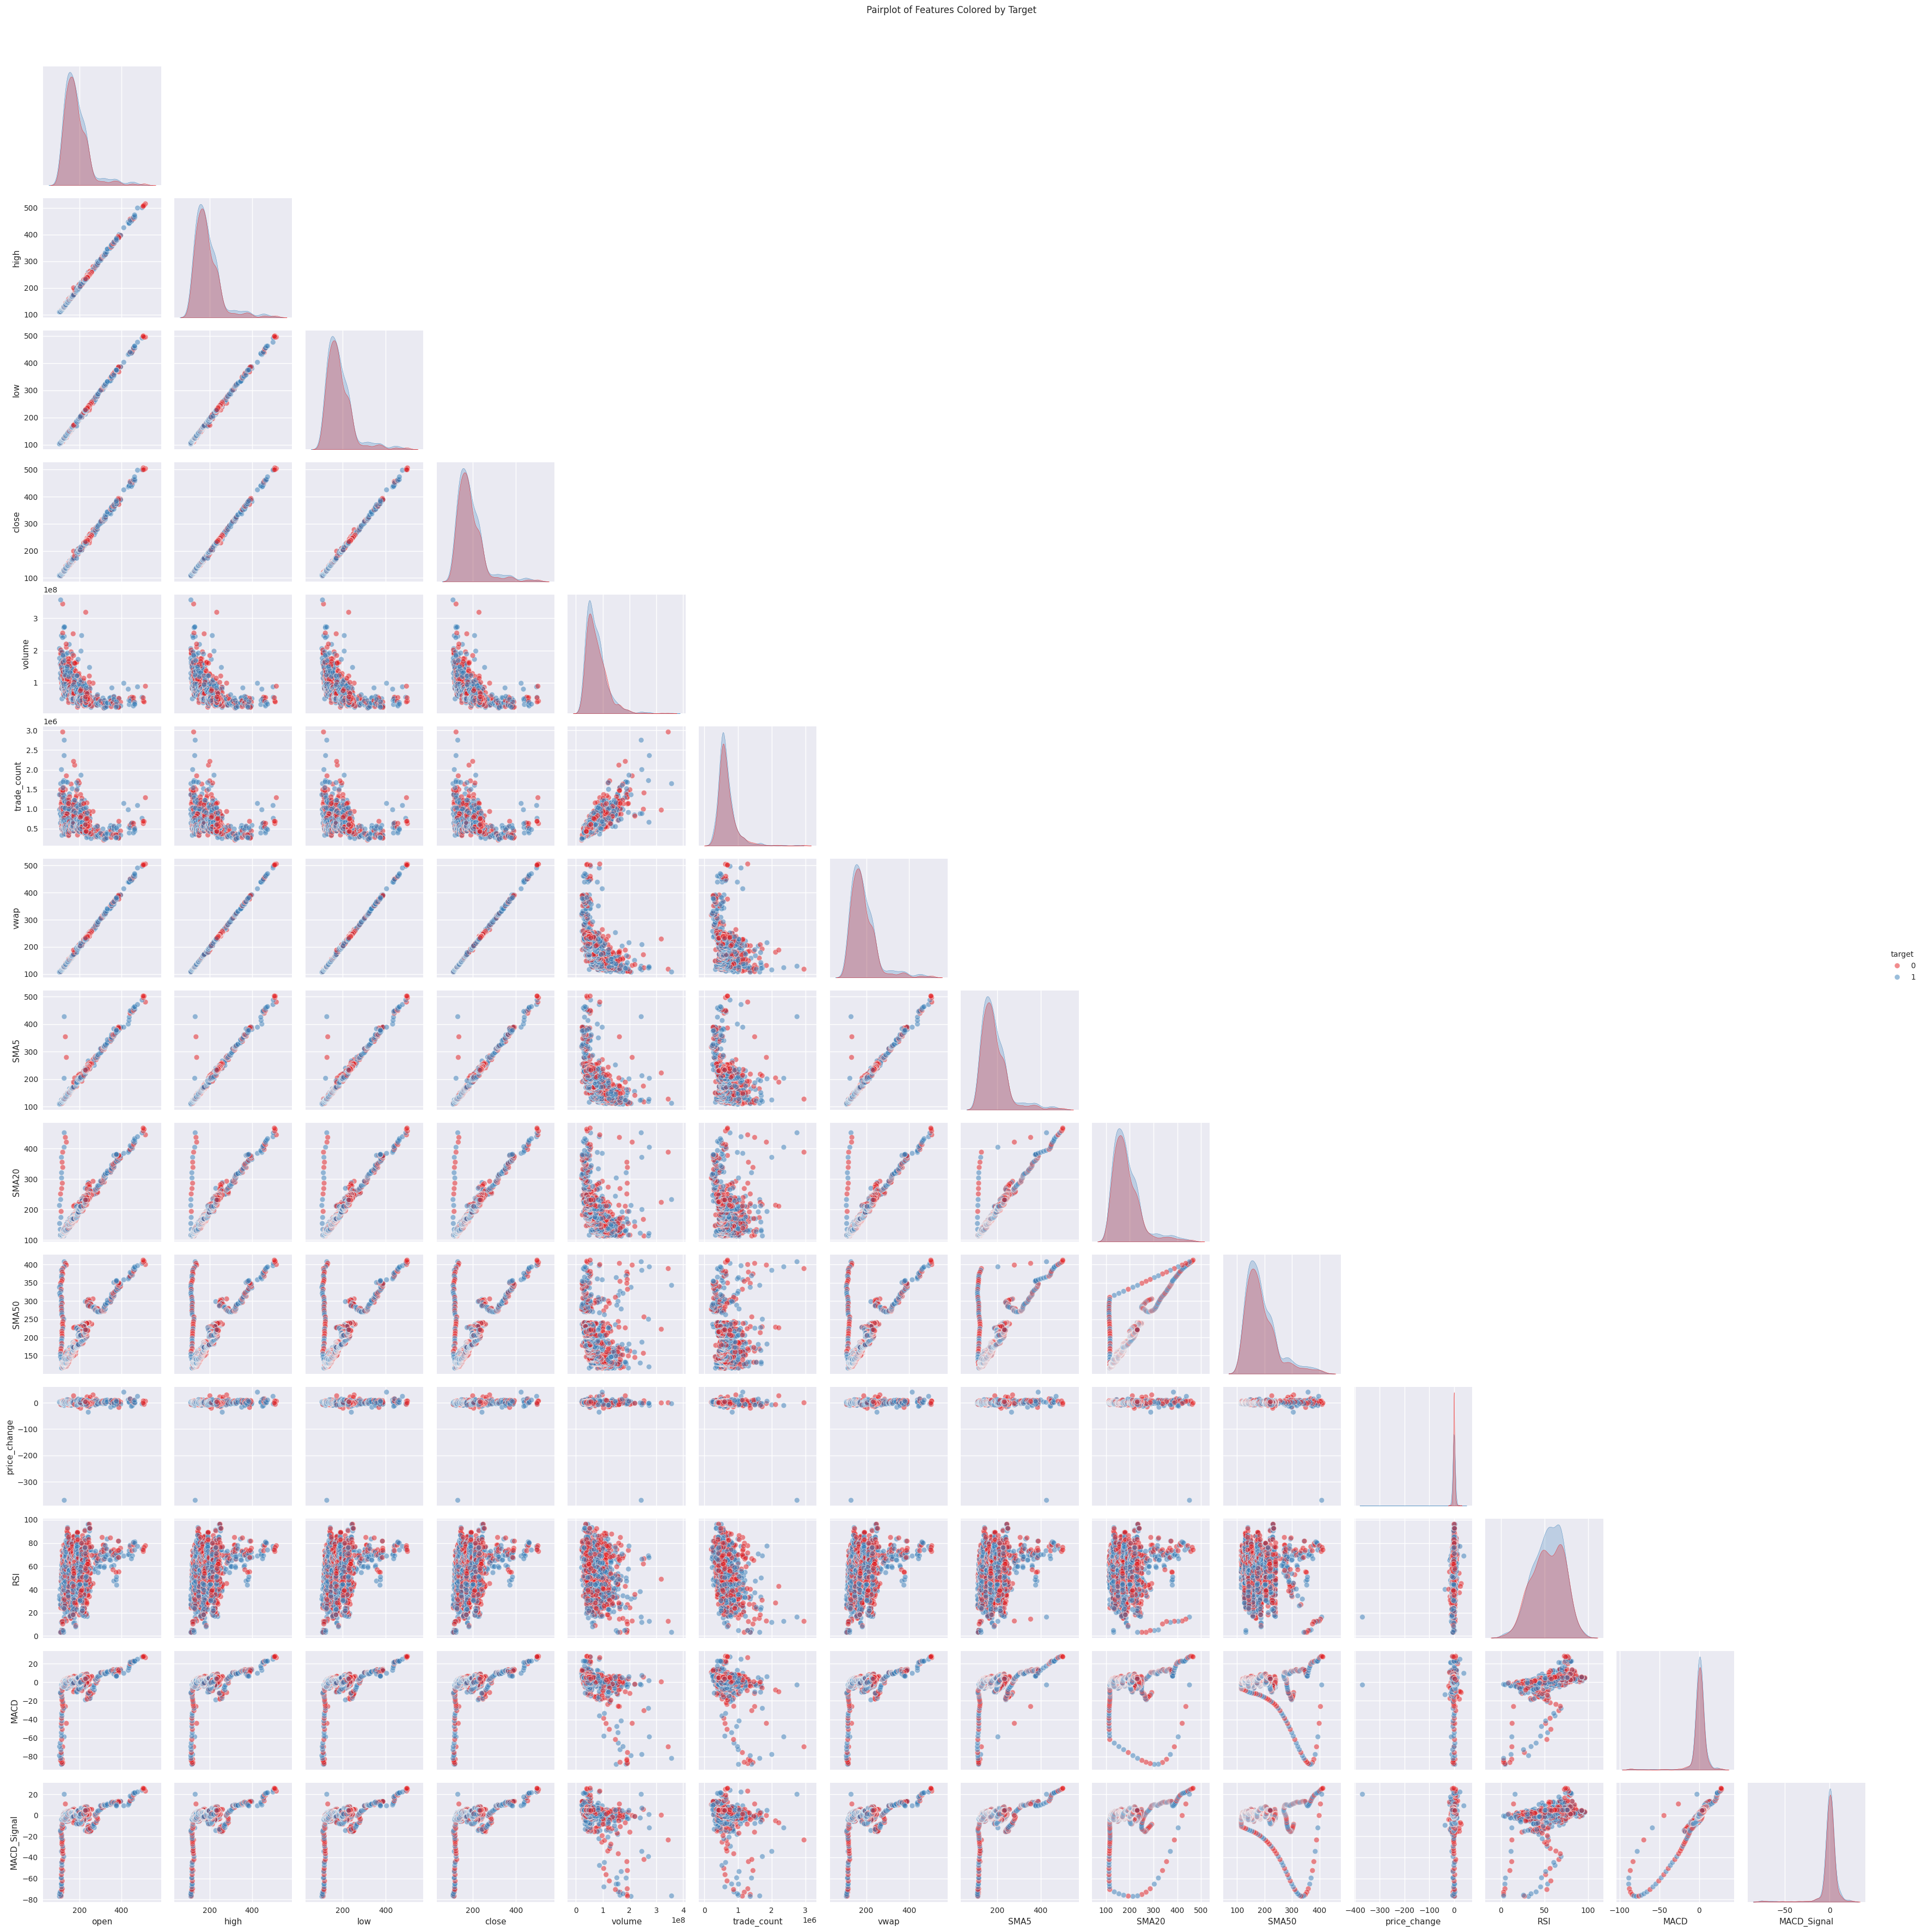

In [25]:
features = ['open', 'high', 'low', 'close', 'volume', 'trade_count',
            'vwap', 'SMA5', 'SMA20', 'SMA50', 'price_change', 'RSI', 'MACD', 'MACD_Signal', 'target']

# Pairplot
sns.pairplot(df[features], hue = 'target', corner = True, palette = 'Set1', diag_kind = 'kde', plot_kws = {'alpha':0.5})
plt.suptitle("Pairplot of Features Colored by Target", y = 1.02)
plt.show()

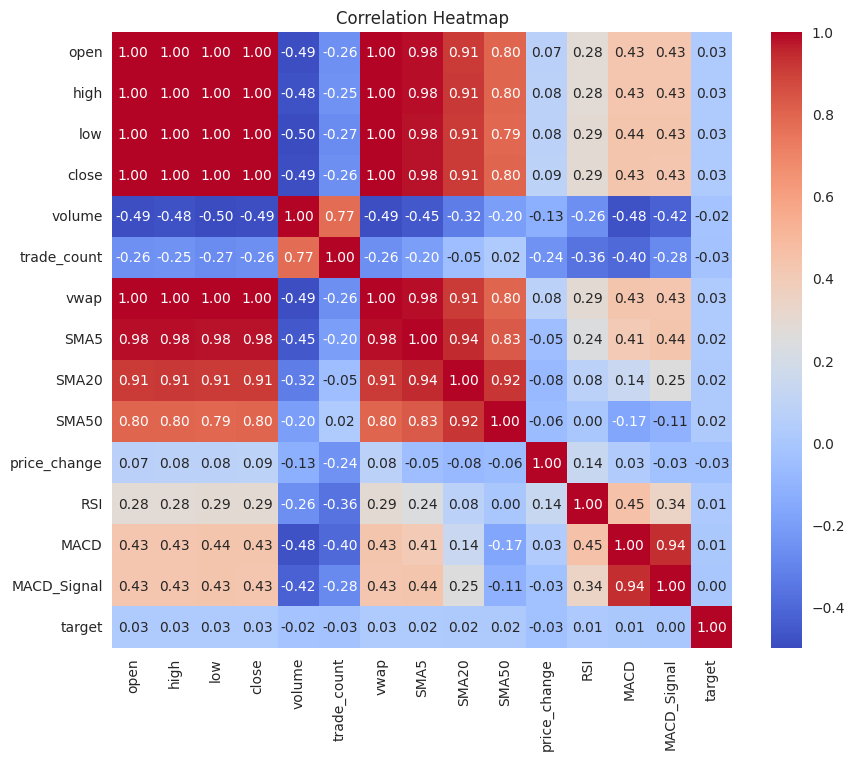

In [26]:
# Compute correlations
corr = df[features].corr()

# Heatmap
plt.figure(figsize = (10,8))
sns.heatmap(corr, annot = True, fmt = ".2f", cmap = 'coolwarm', cbar = True)
plt.title("Correlation Heatmap")
plt.show()

In [27]:
# Creating ColoumnTransformer
numeric_features = ['open','high','low','close','volume','trade_count','vwap',
                    'SMA5','SMA20','SMA50','price_change','RSI','MACD','MACD_Signal']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components = 0.95))
    ]), numeric_features)
])

X = df[features]
y = df['target'].loc[X.index]  # align target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, shuffle = False
)

### Modelling

In [28]:
pipelines = {
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier(random_state = 42))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessor', preprocessor),
        ('clf', GradientBoostingClassifier(random_state = 42))
    ]),
    'SVC': Pipeline([
        ('preprocessor', preprocessor),
        ('clf', SVC(probability = True, random_state = 42))
    ])
}

param_distributions = {
    'RandomForest': {
        'clf__n_estimators': randint(50, 300),
        'clf__max_depth': randint(3, 20),
        'preprocessor__num__pca__n_components': randint(3, 8)
    },
    'GradientBoosting': {
        'clf__n_estimators': randint(50, 300),
        'clf__learning_rate': uniform(0.01, 0.3),
        'clf__max_depth': randint(3, 10),
        'preprocessor__num__pca__n_components': randint(3, 8)
    },
    'SVC': {
        'clf__C': uniform(0.1, 10),
        'clf__kernel': ['linear', 'rbf'],
        'preprocessor__num__pca__n_components': randint(3, 8)
    }
}

#### Training

In [29]:
best_models = {}

for name in pipelines:
    rs = RandomizedSearchCV(
        pipelines[name],
        param_distributions=param_distributions[name],
        n_iter = 20,  # number of random combinations
        scoring = 'f1',  # optimize F1-score
        cv = 3,
        verbose = 2,
        n_jobs = 1,
        random_state = 42
    )
    rs.fit(X_train, y_train)
    best_models[name] = rs.best_estimator_
    print(f"Best {name} params: {rs.best_params_}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END clf__max_depth=9, clf__n_estimators=229, preprocessor__num__pca__n_components=7; total time=   0.5s
[CV] END clf__max_depth=9, clf__n_estimators=229, preprocessor__num__pca__n_components=7; total time=   0.5s
[CV] END clf__max_depth=9, clf__n_estimators=229, preprocessor__num__pca__n_components=7; total time=   0.5s
[CV] END clf__max_depth=17, clf__n_estimators=156, preprocessor__num__pca__n_components=7; total time=   0.4s
[CV] END clf__max_depth=17, clf__n_estimators=156, preprocessor__num__pca__n_components=7; total time=   0.4s
[CV] END clf__max_depth=17, clf__n_estimators=156, preprocessor__num__pca__n_components=7; total time=   0.3s
[CV] END clf__max_depth=9, clf__n_estimators=171, preprocessor__num__pca__n_components=5; total time=   0.4s
[CV] END clf__max_depth=9, clf__n_estimators=171, preprocessor__num__pca__n_components=5; total time=   0.3s
[CV] END clf__max_depth=9, clf__n_estimators=171, preprocessor__

We will choose **LSTM** models for this project, however more experimenting with the achitecture and test plotting will be done in another notebook. We will also use F1 and accuracy for validation and testing. We will primarily f1-score since it is more useful for "buy"-signals.

In [65]:
# LSTM, let us try a sequencial model
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5
X_seq, y_seq = create_sequences(X, y, time_steps)

# Train/test split
split = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

# Build LSTM model
def build_lstm():
    model = Sequential()
    model.add(LSTM(10, activation = 'relu', input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = ks.losses.BinaryCrossentropy(), 
                  optimizer = ks.optimizers.Adam(), 
                  metrics = ['accuracy'])
    return model

lstm_model = build_lstm()
lstm_model.fit(X_train_seq, y_train_seq, 
               epochs = 5, 
               batch_size = 20, 
               validation_split = 0.1, 
               verbose = 2)


/tmp/ipykernel_14579/3314684875.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i + time_steps])


Epoch 1/5
50/50 - 3s - 54ms/step - accuracy: 0.5035 - loss: 0.6932 - val_accuracy: 0.5946 - val_loss: 0.6927
Epoch 2/5
50/50 - 0s - 7ms/step - accuracy: 0.5217 - loss: 0.6930 - val_accuracy: 0.5946 - val_loss: 0.6918
Epoch 3/5
50/50 - 0s - 6ms/step - accuracy: 0.5217 - loss: 0.6928 - val_accuracy: 0.5946 - val_loss: 0.6912
Epoch 4/5
50/50 - 0s - 6ms/step - accuracy: 0.5217 - loss: 0.6927 - val_accuracy: 0.5946 - val_loss: 0.6904
Epoch 5/5
50/50 - 0s - 6ms/step - accuracy: 0.5217 - loss: 0.6926 - val_accuracy: 0.5946 - val_loss: 0.6899


### Evaluation

In [66]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("F1-score:", f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("\n")

# Evaluate LSTM
y_pred_seq = (lstm_model.predict(X_test_seq) > 0.5).astype(int)
print("LSTM F1-score:", f1_score(y_test_seq, y_pred_seq))


--- RandomForest ---
F1-score: 0.6924939467312349
              precision    recall  f1-score   support

           0       0.50      0.06      0.10       127
           1       0.54      0.95      0.69       150

    accuracy                           0.54       277
   macro avg       0.52      0.50      0.40       277
weighted avg       0.52      0.54      0.42       277



--- GradientBoosting ---
F1-score: 0.5034965034965035
              precision    recall  f1-score   support

           0       0.45      0.50      0.47       127
           1       0.53      0.48      0.50       150

    accuracy                           0.49       277
   macro avg       0.49      0.49      0.49       277
weighted avg       0.49      0.49      0.49       277



--- SVC ---
F1-score: 0.702576112412178
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       127
           1       0.54      1.00      0.70       150

    accuracy                      

/home/milad/repositories/Live-Trading-Platform/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/milad/repositories/Live-Trading-Platform/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/milad/repositories/Live-Trading-Platform/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
LSTM F1-score: 0.7011764705882353
